<a href="https://colab.research.google.com/github/ricky-kiva/andro-aad-sim-course/blob/main/m6_p1_rps_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Rock Paper Scissors Classification**

*   Name: Ricky Fadel M
*   Username: rickyslash
*   Email: ricky.kiva@mail.ugm.ac.id



In [21]:
# import libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import shutil
import time
import os

from tensorflow import keras

%matplotlib inline

Download dataset

In [22]:
!wget -q --no-check-certificate \
  https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip \
  -O './rockpaperscissors.zip'

Extract dataset

In [23]:
data_dir = './data'

local_zip = './rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(data_dir)

zip_ref.close()

Explore extracted data

In [24]:
base_dir = os.path.join(data_dir, 'rockpaperscissors')

extracted_content = os.listdir(base_dir)

Clean data directory

In [25]:
unused_contents = [item for item in extracted_content
                   if item not in ['rock', 'paper', 'scissors']]

for path_ in unused_contents:
  unused_path = os.path.join(base_dir, path_)
  if os.path.exists(unused_path):
    if os.path.isfile(unused_path):
      os.remove(unused_path)
    elif os.path.isdir(unused_path):
      shutil.rmtree(unused_path)
    print(f'{unused_path} successfully removed')
  else:
    print(f'{unused_path} is already nonexist')

./data/rockpaperscissors/rps-cv-images successfully removed
./data/rockpaperscissors/README_rpc-cv-images.txt successfully removed


Explore dataset

In [26]:
# check available classes
classes = os.listdir(base_dir)
print(f'Classes: {classes}\n')

Classes: ['paper', 'scissors', 'rock']



In [27]:
total_sample = 0

# check number of sample in each class
for class_ in classes:
  sample_n = len(os.listdir(os.path.join(base_dir, class_)))
  print(f'Samples in {class_}: {sample_n}')
  total_sample += sample_n

print(f'\nTotal sample: {total_sample}')

Samples in paper: 712
Samples in scissors: 750
Samples in rock: 726

Total sample: 2188


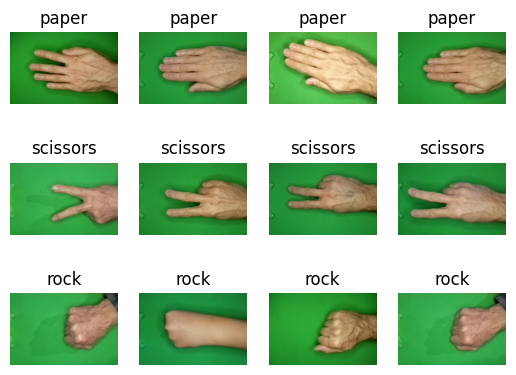

In [28]:
import matplotlib.image as mpimg

fig, axes = plt.subplots(len(classes), 4)

for i, class_name in enumerate(classes):
  class_dir = os.path.join(base_dir, class_name)
  images = os.listdir(class_dir)[:4]

  for j, image_name in enumerate(images):
    image_path = os.path.join(class_dir, image_name)
    ax = axes[i, j]
    ax.axis('off')

    img = mpimg.imread(image_path)
    ax.imshow(img)

    ax.set_title(class_name)

plt.show()

In [29]:
# check sample shape
print(img.shape)

(200, 300, 3)


**Image Augmentation** while building *ImageDataGenerator*

In [30]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1/255,
    zoom_range=0.2, # extra image augmentation
    vertical_flip=True, # extra image augmentation
    brightness_range=[0.8, 1.2], # extra image augmentation
    channel_shift_range=0.2, # extra image augmentation
    rotation_range=40,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest',
    validation_split=0.4 # 60% for train set
)

validation_datagen = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.4 # 40% for validation set
)

Flow the data to the generator

In [31]:
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training' # get the train set
)

validation_generator = validation_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    subset='validation' # get the validation set
)

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


**Note:**
*   Train set: 1314 samples
*   Validation set: 874 samples



Visualize data from *Train & Validation Generator*

TRAIN GENERATOR:


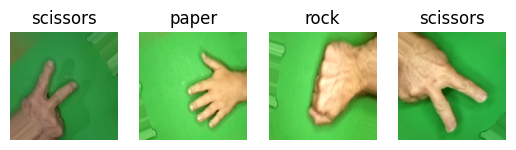


VALIDATION GENERATOR:


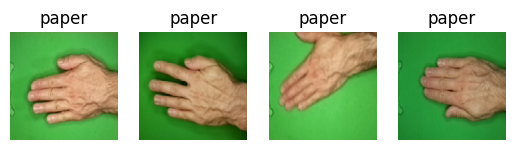

In [32]:
def plot_generator_img(generator, num_samples=4):
    classes = list(generator.class_indices.keys())

    x, y = generator.next()

    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(x[i])
        plt.title(classes[y[i].argmax()])
        plt.axis('off')

    plt.show()

print('TRAIN GENERATOR:')
plot_generator_img(train_generator)

print('\nVALIDATION GENERATOR:')
plot_generator_img(validation_generator)

Make the model

In [42]:
from keras.regularizers import l2

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(256, (3,3), strides=(2, 2), activation='relu', padding='same'), # 1st technique: implement padding & strides
    tf.keras.layers.MaxPooling2D((2,2), padding='same'),

    tf.keras.layers.Conv2D(512, (3,3), strides=(2, 2), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2), padding='same'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2), # 2nd technique: use Dropout layer
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)), # 3rd technique: use L2 kernel regularizer
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)), # use more than 1 hidden layer
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 74, 74, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 36, 36, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 18, 18, 256)       295168    
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 9, 9, 256)        

Create Callback class

In [34]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('accuracy') > 0.97
        and logs.get('val_accuracy') > 0.9
        and logs.get('val_loss') < 0.2):
      print("\n`Accuracy` is higher than 97%, `Val. Accuracy` is higher than 90% & `Val. Loss` is lower than 0.2. Cancelling the training!")
      self.model.stop_training = True

Instantiate Callback

In [35]:
callbacks = myCallback()

Compile & train the model

In [36]:
TRAIN_STEP = len(train_generator)
print(f'Train step: {TRAIN_STEP}')

VALIDATION_STEP = len(validation_generator)
print(f'Validation step: {VALIDATION_STEP}')

Train step: 42
Validation step: 28


In [43]:
from keras.optimizers import RMSprop

# 4th technique: modify learning rate
model.compile(optimizer=RMSprop(learning_rate=0.0006), # use different optimizer
              loss=tf.keras.losses.CategoricalCrossentropy(), # use different loss
              metrics=['accuracy'])

start_time = time.time()

history = model.fit(train_generator,
                    steps_per_epoch=TRAIN_STEP,
                    epochs=35,
                    validation_data=validation_generator,
                    validation_steps=VALIDATION_STEP,
                    verbose=2,
                    callbacks=[callbacks]) # 5th technique: implement Callbacks

end_time = time.time()
train_time = end_time - start_time

Epoch 1/35
42/42 - 17s - loss: 1.8175 - accuracy: 0.3699 - val_loss: 1.7012 - val_accuracy: 0.3455 - 17s/epoch - 410ms/step
Epoch 2/35
42/42 - 18s - loss: 1.5932 - accuracy: 0.4429 - val_loss: 1.3008 - val_accuracy: 0.7140 - 18s/epoch - 421ms/step
Epoch 3/35
42/42 - 15s - loss: 1.2950 - accuracy: 0.6476 - val_loss: 0.9373 - val_accuracy: 0.8135 - 15s/epoch - 360ms/step
Epoch 4/35
42/42 - 15s - loss: 0.9899 - accuracy: 0.7336 - val_loss: 0.6158 - val_accuracy: 0.9073 - 15s/epoch - 353ms/step
Epoch 5/35
42/42 - 15s - loss: 0.7858 - accuracy: 0.8120 - val_loss: 0.6132 - val_accuracy: 0.9371 - 15s/epoch - 349ms/step
Epoch 6/35
42/42 - 15s - loss: 0.6584 - accuracy: 0.8501 - val_loss: 0.4874 - val_accuracy: 0.9108 - 15s/epoch - 355ms/step
Epoch 7/35
42/42 - 15s - loss: 0.5601 - accuracy: 0.8767 - val_loss: 0.3661 - val_accuracy: 0.9439 - 15s/epoch - 356ms/step
Epoch 8/35
42/42 - 15s - loss: 0.5112 - accuracy: 0.8752 - val_loss: 0.3542 - val_accuracy: 0.9371 - 15s/epoch - 369ms/step
Epoch 9/

Model final accuracy & train time

In [45]:
final_accuracy = history.history['accuracy'][-1]
print(f'Final training accuracy: {final_accuracy * 100:.2f}%')

print(f'Training time: {((train_time)/60):.2f} minutes')

Final training accuracy: 97.26%
Training time: 7.17 minutes


Plot train & validation result

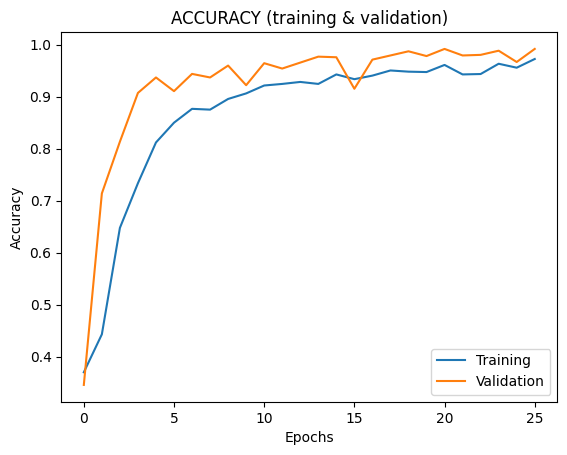

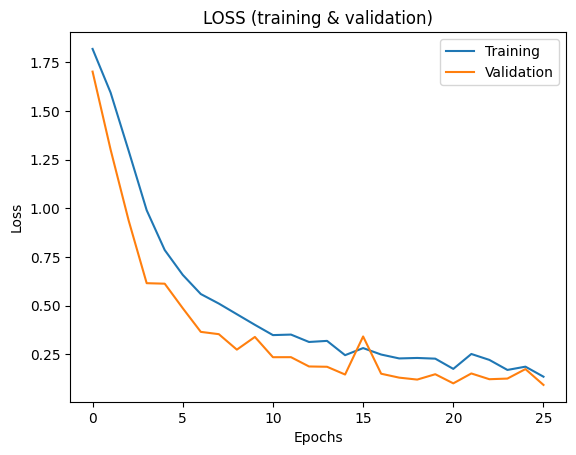

In [44]:
import matplotlib.pyplot as plt

# get data from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# get epochs data
epochs = range(len(acc))

# plot accuracy data
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.title('ACCURACY (training & validation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# plot loss data
plt.figure()
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.title('LOSS (training & validation)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

**Predict Image(s)** using external resources

Saving download (1).png to download (1) (2).png
Saving download (2).png to download (2) (2).png
Saving download.png to download (4).png
1/1 [==============================] - 0s 82ms/step

Predicted value: Paper
Confidence: 0.9883655309677124
Prediction: [9.8836553e-01 1.9145114e-04 1.1443033e-02]


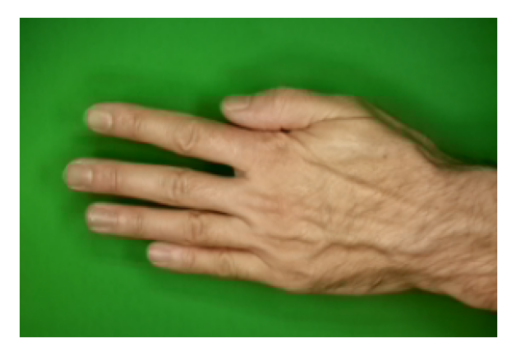

1/1 [==============================] - 0s 17ms/step

Predicted value: Rock
Confidence: 0.9920949339866638
Prediction: [0.0035592  0.99209493 0.00434579]


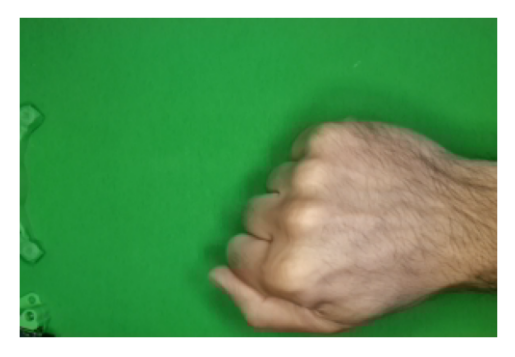

1/1 [==============================] - 0s 17ms/step

Predicted value: Scissors
Confidence: 0.9777179956436157
Prediction: [0.02123901 0.00104297 0.977718  ]


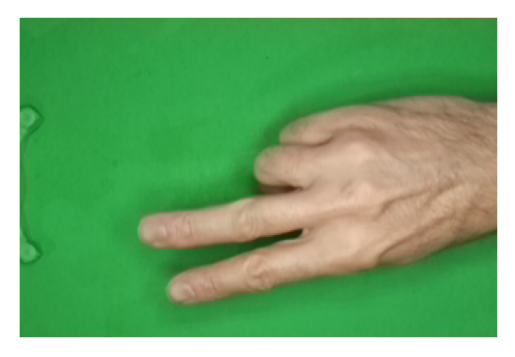

In [46]:
from google.colab import files
from keras.preprocessing import image
import matplotlib.image as mpimg

uploaded = files.upload()

for fn in uploaded.keys():

  path = fn
  img = image.load_img(path, target_size=(150, 150))

  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = (model.predict(images, batch_size=10))[0]

  label_pred_val = '\nPredicted value: '
  pred_val = np.argmax(classes)
  if(pred_val == 0):
    print(label_pred_val + 'Paper')
  elif(pred_val == 1):
    print(label_pred_val + 'Rock')
  else:
    print(label_pred_val + 'Scissors')

  print(f'Confidence: {max(classes)}')
  print(f'Prediction: {classes}')

  img = mpimg.imread(path)
  plt.figure()
  plt.imshow(img)
  plt.axis('off')
  plt.show()